In [1]:
from keras.engine.topology import Layer
import keras.backend as K


class SpatialPyramidPooling(Layer):
    """Spatial pyramid pooling layer for 2D inputs.
    See Spatial Pyramid Pooling in Deep Convolutional Networks for Visual Recognition,
    K. He, X. Zhang, S. Ren, J. Sun
    # Arguments
        pool_list: list of int
            List of pooling regions to use. The length of the list is the number of pooling regions,
            each int in the list is the number of regions in that pool. For example [1,2,4] would be 3
            regions with 1, 2x2 and 4x4 max pools, so 21 outputs per feature map
    # Input shape
        4D tensor with shape:
        `(samples, channels, rows, cols)` if dim_ordering='th'
        or 4D tensor with shape:
        `(samples, rows, cols, channels)` if dim_ordering='tf'.
    # Output shape
        2D tensor with shape:
        `(samples, channels * sum([i * i for i in pool_list])`
    """

    def __init__(self, pool_list, **kwargs):

        self.dim_ordering = K.image_dim_ordering()
        assert self.dim_ordering in {'tf', 'th'}, 'dim_ordering must be in {tf, th}'

        self.pool_list = pool_list

        self.num_outputs_per_channel = sum([i * i for i in pool_list])

        super(SpatialPyramidPooling, self).__init__(**kwargs)

    def build(self, input_shape):
        if self.dim_ordering == 'th':
            self.nb_channels = input_shape[1]
        elif self.dim_ordering == 'tf':
            self.nb_channels = input_shape[3]

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.nb_channels * self.num_outputs_per_channel)

    def get_config(self):
        config = {'pool_list': self.pool_list}
        base_config = super(SpatialPyramidPooling, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def call(self, x, mask=None):

        input_shape = K.shape(x)

        if self.dim_ordering == 'th':
            num_rows = input_shape[2]
            num_cols = input_shape[3]
        elif self.dim_ordering == 'tf':
            num_rows = input_shape[1]
            num_cols = input_shape[2]

        row_length = [K.cast(num_rows, 'float32') / i for i in self.pool_list]
        col_length = [K.cast(num_cols, 'float32') / i for i in self.pool_list]

        outputs = []

        if self.dim_ordering == 'th':
            for pool_num, num_pool_regions in enumerate(self.pool_list):
                for jy in range(num_pool_regions):
                    for ix in range(num_pool_regions):
                        x1 = ix * col_length[pool_num]
                        x2 = ix * col_length[pool_num] + col_length[pool_num]
                        y1 = jy * row_length[pool_num]
                        y2 = jy * row_length[pool_num] + row_length[pool_num]

                        x1 = K.cast(K.round(x1), 'int32')
                        x2 = K.cast(K.round(x2), 'int32')
                        y1 = K.cast(K.round(y1), 'int32')
                        y2 = K.cast(K.round(y2), 'int32')
                        new_shape = [input_shape[0], input_shape[1],
                                     y2 - y1, x2 - x1]
                        x_crop = x[:, :, y1:y2, x1:x2]
                        xm = K.reshape(x_crop, new_shape)
                        pooled_val = K.max(xm, axis=(2, 3))
                        outputs.append(pooled_val)

        elif self.dim_ordering == 'tf':
            for pool_num, num_pool_regions in enumerate(self.pool_list):
                for jy in range(num_pool_regions):
                    for ix in range(num_pool_regions):
                        x1 = ix * col_length[pool_num]
                        x2 = ix * col_length[pool_num] + col_length[pool_num]
                        y1 = jy * row_length[pool_num]
                        y2 = jy * row_length[pool_num] + row_length[pool_num]

                        x1 = K.cast(K.round(x1), 'int32')
                        x2 = K.cast(K.round(x2), 'int32')
                        y1 = K.cast(K.round(y1), 'int32')
                        y2 = K.cast(K.round(y2), 'int32')

                        new_shape = [input_shape[0], y2 - y1,
                                     x2 - x1, input_shape[3]]

                        x_crop = x[:, y1:y2, x1:x2, :]
                        xm = K.reshape(x_crop, new_shape)
                        pooled_val = K.max(xm, axis=(1, 2))
                        outputs.append(pooled_val)

        if self.dim_ordering == 'th':
            outputs = K.concatenate(outputs)
        elif self.dim_ordering == 'tf':
            #outputs = K.concatenate(outputs,axis = 1)
            outputs = K.concatenate(outputs)
            #outputs = K.reshape(outputs,(len(self.pool_list),self.num_outputs_per_channel,input_shape[0],input_shape[1]))
            #outputs = K.permute_dimensions(outputs,(3,1,0,2))
            #outputs = K.reshape(outputs,(input_shape[0], self.num_outputs_per_channel * self.nb_channels))

        return outputs

Using TensorFlow backend.


In [2]:
from keras import layers
from keras import models
import keras.backend as K
from keras import optimizers
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

In [3]:
K.clear_session()
model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(None, None, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(SpatialPyramidPooling([1,2,4]))
model.add(Dense(512, activation='relu'))
model.add(layers.Dense(8, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, None, None, 32)    896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, None, None, 32)    0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 64)    18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, None, None, 64)    0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 128)   73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, None, None, 128)   0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, None, None, 128)   147584    
__________

In [4]:
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['acc'])

In [5]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

In [6]:
train_dir = './data/natural_deep/train'
validation_dir = './data/natural_deep/validation'
test_dir = './data/natural_deep/test'

In [7]:
train_dir_dog = './data/natural_deep/train/dog'

In [8]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

In [9]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [10]:
train_generator = train_datagen.flow_from_directory(train_dir,
                                                   #target_size=(224,224),
                                                   batch_size=8,
                                                   class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                        #target_size=(224,224),
                                                        batch_size=8,
                                                        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(test_dir,
                                                  #target_size=(224, 224),
                                                  batch_size=8,
                                                  class_mode='categorical')

Found 3200 images belonging to 8 classes.
Found 1600 images belonging to 8 classes.
Found 800 images belonging to 8 classes.


In [11]:
early_stopping_callback = EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, 
                                        mode='auto', baseline=None, restore_best_weights=False)

In [12]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=1200,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=200,
    callbacks=[early_stopping_callback]
)

Epoch 1/100
1200/1200 [==============================] - 191s 159ms/step - loss: 0.9914 - acc: 0.6269 - val_loss: 0.4649 - val_acc: 0.8306
Epoch 2/100
1200/1200 [==============================] - 193s 161ms/step - loss: 0.5432 - acc: 0.8007 - val_loss: 0.4084 - val_acc: 0.8462
Epoch 3/100
1200/1200 [==============================] - 194s 162ms/step - loss: 0.4349 - acc: 0.8381 - val_loss: 0.3401 - val_acc: 0.8756
Epoch 4/100
1200/1200 [==============================] - 194s 162ms/step - loss: 0.3689 - acc: 0.8643 - val_loss: 0.4162 - val_acc: 0.8544


In [13]:
model.evaluate_generator(test_generator, steps=200)

[0.4150760173471644, 0.85125]

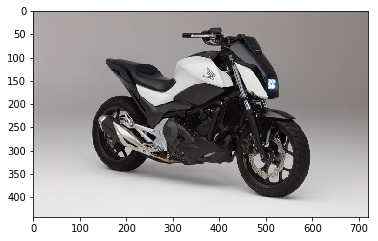

In [35]:
img_path = 'my_motorbike.jpg'
img = image.load_img(img_path)
plt.imshow(img)

In [36]:
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x/255.
pred=model.predict(x)

In [37]:
for name, number in test_generator.class_indices.items():
    if number == np.argmax(pred):
        print('pred :', name)

pred : dog
